**1.Target:**

Create Basic model architecture

**2.Results:**

1.  Parameters: 119,392
2.  Best Train Accuracy: 99.32
3.  Best Test Accuracy: 98.51



**3.Analysis:**

Number of paramter is too high and model is also overfitting need to reduce the parameter

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [ ]:
dropout_value = .05
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels= 32,kernel_size= (3, 3), padding=1, bias=False),    #output_image = 28, RF=3
            nn.ReLU()
            )
        #CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32,out_channels= 64,kernel_size= (3, 3), padding=1, bias=False),    #output_image = 28, RF=5
            nn.ReLU()
        )

        #TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2)    #output_image = 14, RF=6
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=64,out_channels= 128,kernel_size= (1, 1), padding=0, bias=False),    #output_image = 14, RF=6
            nn.ReLU())


        #CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=128,out_channels= 64,kernel_size= (3, 3), padding=1, bias=False),    #output_image = 14, RF=10
            nn.ReLU()
        )
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=64,out_channels= 32,kernel_size= (3, 3), padding=1, bias=False),    #output_image = 14, RF=14
            nn.ReLU()

        )

        #TRANSITION BLOCK 2
        self.pool2 = nn.MaxPool2d(2, 2)    #output_image = 7, RF=16
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32,out_channels= 10,kernel_size= (1, 1), padding=0, bias=False),    #output_image = 7, RF=24
            nn.ReLU()
        )

        #CONVOLUTION BLOCK 3
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=7),
            #nn.Conv2d(in_channels=10,out_channels= 10,kernel_size= (7, 7), padding=0, bias=False),    #output_image = 1, RF=32

        )


    def forward(self, x):
      x = self.convblock1(x)
      x = self.convblock2(x)
      x = self.pool1(x)
      x = self.convblock3(x)
      x = self.convblock4(x)
      x = self.convblock5(x)
      x = self.pool2(x)
      x = self.convblock6(x)
      x = self.gap(x)
      x = x.view(-1, 10)
      return F.log_softmax(x, dim=-1)

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             288
              ReLU-2           [-1, 32, 28, 28]               0
            Conv2d-3           [-1, 64, 28, 28]          18,432
              ReLU-4           [-1, 64, 28, 28]               0
         MaxPool2d-5           [-1, 64, 14, 14]               0
            Conv2d-6          [-1, 128, 14, 14]           8,192
              ReLU-7          [-1, 128, 14, 14]               0
            Conv2d-8           [-1, 64, 14, 14]          73,728
              ReLU-9           [-1, 64, 14, 14]               0
           Conv2d-10           [-1, 32, 14, 14]          18,432
             ReLU-11           [-1, 32, 14, 14]               0
        MaxPool2d-12             [-1, 32, 7, 7]               0

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=2.300823211669922 Batch_id=468 Accuracy=9.82: 100%|██████████| 469/469 [00:23<00:00, 19.57it/s]



Test set: Average loss: 2.2919, Accuracy: 980/10000 (9.80%)

EPOCH: 1


Loss=0.913248598575592 Batch_id=468 Accuracy=27.45: 100%|██████████| 469/469 [00:18<00:00, 25.04it/s]



Test set: Average loss: 0.7595, Accuracy: 7730/10000 (77.30%)

EPOCH: 2


Loss=0.14390675723552704 Batch_id=468 Accuracy=88.79: 100%|██████████| 469/469 [00:17<00:00, 26.63it/s]



Test set: Average loss: 0.2222, Accuracy: 9339/10000 (93.39%)

EPOCH: 3


Loss=0.14291684329509735 Batch_id=468 Accuracy=94.62: 100%|██████████| 469/469 [00:18<00:00, 24.76it/s]



Test set: Average loss: 0.1274, Accuracy: 9631/10000 (96.31%)

EPOCH: 4


Loss=0.1120203360915184 Batch_id=468 Accuracy=95.88: 100%|██████████| 469/469 [00:18<00:00, 25.45it/s]



Test set: Average loss: 0.0961, Accuracy: 9710/10000 (97.10%)

EPOCH: 5


Loss=0.026584068313241005 Batch_id=468 Accuracy=96.74: 100%|██████████| 469/469 [00:18<00:00, 25.33it/s]



Test set: Average loss: 0.1124, Accuracy: 9647/10000 (96.47%)

EPOCH: 6


Loss=0.10065159201622009 Batch_id=468 Accuracy=96.97: 100%|██████████| 469/469 [00:19<00:00, 23.48it/s]



Test set: Average loss: 0.1044, Accuracy: 9681/10000 (96.81%)

EPOCH: 7


Loss=0.1213020607829094 Batch_id=468 Accuracy=97.34: 100%|██████████| 469/469 [00:18<00:00, 26.04it/s]



Test set: Average loss: 0.0706, Accuracy: 9782/10000 (97.82%)

EPOCH: 8


Loss=0.040774885565042496 Batch_id=468 Accuracy=97.64: 100%|██████████| 469/469 [00:19<00:00, 24.58it/s]



Test set: Average loss: 0.0813, Accuracy: 9732/10000 (97.32%)

EPOCH: 9


Loss=0.1523200124502182 Batch_id=468 Accuracy=97.81: 100%|██████████| 469/469 [00:17<00:00, 26.32it/s]



Test set: Average loss: 0.0655, Accuracy: 9793/10000 (97.93%)

EPOCH: 10


Loss=0.0388328842818737 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:19<00:00, 24.06it/s]



Test set: Average loss: 0.0704, Accuracy: 9783/10000 (97.83%)

EPOCH: 11


Loss=0.0266944020986557 Batch_id=468 Accuracy=98.07: 100%|██████████| 469/469 [00:18<00:00, 25.81it/s]



Test set: Average loss: 0.0646, Accuracy: 9803/10000 (98.03%)

EPOCH: 12


Loss=0.014029954560101032 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:18<00:00, 25.74it/s]



Test set: Average loss: 0.0597, Accuracy: 9813/10000 (98.13%)

EPOCH: 13


Loss=0.131007581949234 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:19<00:00, 23.62it/s]



Test set: Average loss: 0.0537, Accuracy: 9834/10000 (98.34%)

EPOCH: 14


Loss=0.08470260351896286 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:18<00:00, 25.15it/s]



Test set: Average loss: 0.0536, Accuracy: 9851/10000 (98.51%)



Text(0.5, 1.0, 'Test Accuracy')

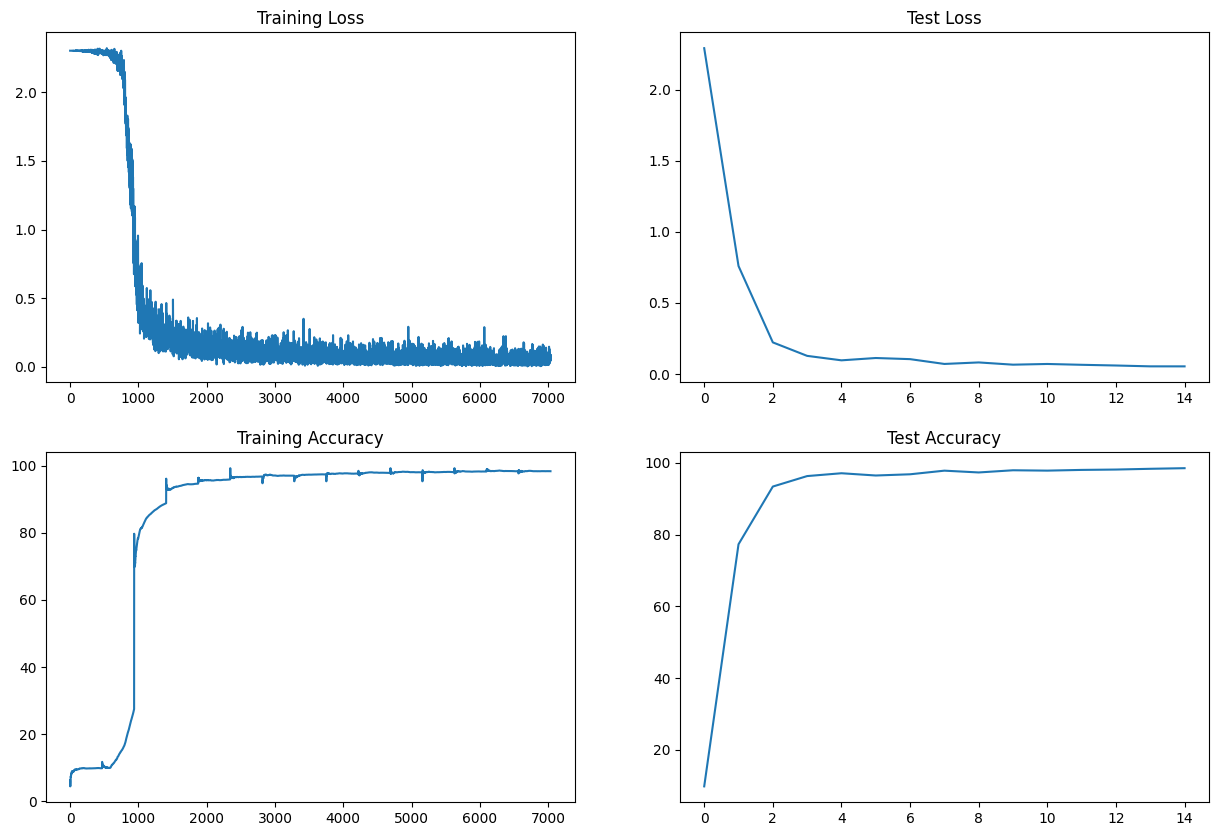

In [ ]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")